
# Forward Simulation of Gravity Anomaly Data on a Tensor Mesh

Here we use the module *SimPEG.potential_fields.gravity* to predict gravity
anomaly data for a synthetic density contrast model. The simulation is
carried out on a tensor mesh. For this tutorial, we focus on the following:

    - How to create gravity surveys
    - How to predict gravity anomaly data for a density contrast model
    - How to include surface topography
    - The units of the density contrast model and resulting data


## Import Modules




In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz

from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import gravity

save_output = False

# sphinx_gallery_thumbnail_number = 2

## Defining Topography

Surface topography is defined as an (N, 3) numpy array. We create it here but
the topography could also be loaded from a file.




In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

## Defining the Survey

Here, we define survey that will be used for the forward simulation. Gravity
surveys are simple to create. The user only needs an (N, 3) array to define
the xyz locations of the observation locations, and a list of field components
which are to be measured.




In [3]:
# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 5.0
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as strings within
# a list. Here we simulate only the vertical component of gravity anomaly.
components = ["gz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Defining the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey
survey = gravity.survey.Survey(source_field)

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to predict gravity anomaly
data.




In [4]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

## Density Contrast Model and Mapping on Tensor Mesh

Here, we create the density contrast model that will be used to predict
gravity anomaly data and the mapping from the model to the mesh. The model
consists of a less dense block and a more dense sphere.




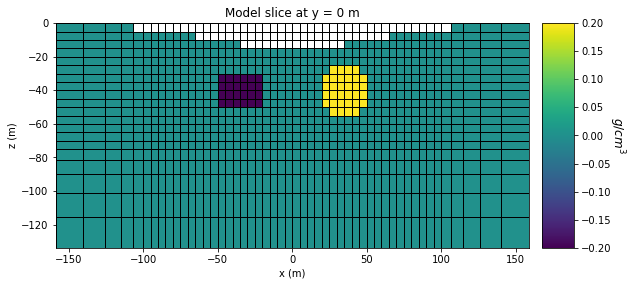

In [8]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

# Find the indices for the active mesh cells (e.g. cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Define model. Models in SimPEG are vector arrays.
model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -50.0)
    & (mesh.gridCC[ind_active, 0] < -20.0)
    & (mesh.gridCC[ind_active, 1] > -15.0)
    & (mesh.gridCC[ind_active, 1] < 15.0)
    & (mesh.gridCC[ind_active, 2] > -50.0)
    & (mesh.gridCC[ind_active, 2] < -30.0)
)
model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.get_indices_sphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_density

# Plot Density Contrast Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

## Simulation: Gravity Anomaly Data on Tensor Mesh

Here we demonstrate how to predict gravity anomaly data using the integral
formulation.




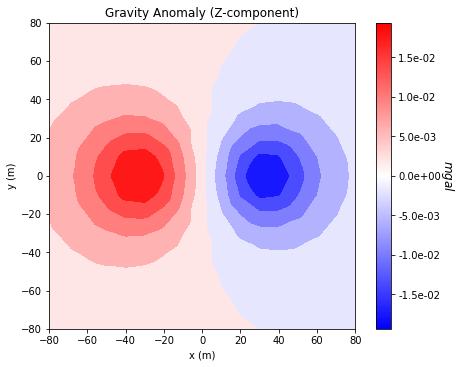

In [6]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
# SimPEG uses right handed coordinate where Z is positive upward.
# This causes gravity signals look "inconsistent" with density values in visualization.
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, dpred, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

## Optional: Exporting Results

Write the data, topography and true model




In [7]:
if save_output:
    dir_path = os.path.dirname(__file__).split(os.path.sep)
    dir_path.extend(["outputs"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    fname = dir_path + "gravity_topo.txt"
    np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

    np.random.seed(737)
    maximum_anomaly = np.max(np.abs(dpred))
    noise = 0.01 * maximum_anomaly * np.random.rand(len(dpred))
    fname = dir_path + "gravity_data.obs"
    np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")